In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [2]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


# Train ESN on ENSO with TDE

First do split, then do embedding!

## Data preperations

### Train, val, test split

In [3]:
sst_1D = CSV.read("data/sst_data/sst_34_format.csv", DataFrame)
train_sst_1D = sst_1D[1:400, "ANOM_3"]
val_sst_1D = sst_1D[401:450, "ANOM_3"]
test_sst_1D = sst_1D[451:500, "ANOM_3"];

### Data embedding

Perform embedding on training data and then use same embedding for validation data

In [4]:
train_sst_emb, τ, E = optimal_separated_de(train_sst_1D) 
train_sst_emb = Matrix(train_sst_emb)';

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


In [5]:
val_sst_emb = embed(val_sst_1D, size(train_sst_emb,1), τ)
val_sst_emb = Matrix(val_sst_emb)';

## Network training v1

take first column of prediction and shift

#### tools

In [ ]:
function esn_eval_pred(esn::ESN, W_out, steps_to_predict::Int64, τ::Int64)
    prediction = esn(Generative(steps_to_predict), W_out)
    return prediction[1,τ+1:end] # changed this line
end

function plot_esn_prediction(esn::ESN, W_out, data::AbstractMatrix, τ::Int64)
    steps_to_predict = size(data,2)
    prediction = esn_eval_pred(esn, W_out, steps_to_predict, τ) # changed this line
    
    label = ["actual" "predicted"]
    times =  collect(0:size(test_sst_1D',2)-τ)[1:end-1] # changed this line
    
    plot(times, [data[1,1:end-τ], prediction], label=label, ylabel="ONI", xlabel="Months", title="Prediction of ENSO using an ESN")
end


function cross_validate_esn(train_data::AbstractMatrix, val_data::AbstractMatrix, param_grid::Vector, τ::Int64)
    best_loss = Inf
    best_params = nothing

    # We want to predict one step ahead, so the input signal is equal to the target signal from the previous step
    # i.e. the sequence is shifted by one step
    u_train = train_data[:, 1:end-1]
    y_train = train_data[:, 2:end]
        
    for hyperparams in param_grid        
        # Unpack the hyperparams struct
        (; reservoir_size, spectral_radius, sparsity, input_scale, ridge_param) = hyperparams

        # Generate and train an ESN
        esn = ESN(
            u_train,
            size(train_data, 1),
            reservoir_size;
            reservoir=rand_sparse(; radius=spectral_radius, sparsity=sparsity),
            input_layer=scaled_rand(; scaling=input_scale),
        )
        Wₒᵤₜ = enso_project.train_esn!(esn, y_train, ridge_param)

        # Evaluate the loss on the validation set
        steps_to_predict = size(val_data[:, τ+1:end], 2) # changed this line
        prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
        loss = sum(abs2, prediction - val_data[:, τ+1:end]) # changed this line. this is wrong TODO
        
        # Keep track of the best hyperparameter values
        if loss < best_loss
            best_loss = loss
            best_params = hyperparams
            println(best_params)
            println("Validation loss = $best_loss")
        end
    end
    
    # Retrain the model using the optimal hyperparameters on both the training and validation data
    # This is necessary because we don't want errors incurred during validation to affect the test error
    (;reservoir_size, spectral_radius, sparsity, input_scale, ridge_param) = best_params
    data = hcat(train_data, val_data)
    u = data[:, 1:end-1]
    y = data[:, 2:end]
    esn = ESN(
        u,
        size(train_data, 1),
        reservoir_size;
        reservoir=rand_sparse(; radius=spectral_radius, sparsity=sparsity),
        input_layer=scaled_rand(; scaling=input_scale),
    )
    Wₒᵤₜ = enso_project.train_esn!(esn, y, ridge_param)
    
    return esn, Wₒᵤₜ, best_loss
end

cross_validate_esn (generic function with 1 method)

#### training

In [156]:
"""spectral_radii = [0.8,0.9,1.0]
sparsities = [0.05, 0.1, 0.2]
input_scales = [0.1,0.8,1.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [100,150,200]"""

spectral_radii = [0.8,1.0]
sparsities = [0.05, 0.1]
input_scales = [0.1,0.8,1.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [100,110,120,130,140,150,160,170,180,190,200]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [157]:
esn, W_out, val_loss = cross_validate_esn(train_sst_emb, val_sst_emb, param_grid, τ)

enso_project.ESNHyperparams(100, 0.8, 0.05, 0.1, 0.0)
Validation loss = 11.242832245532416
enso_project.ESNHyperparams(110, 0.8, 0.05, 0.1, 0.0)
Validation loss = 10.830666731545621
enso_project.ESNHyperparams(140, 0.8, 0.05, 0.1, 0.0)
Validation loss = 10.553887381867195
enso_project.ESNHyperparams(150, 0.8, 0.05, 0.1, 0.0)
Validation loss = 9.5474980656111
enso_project.ESNHyperparams(170, 0.8, 0.05, 0.1, 0.0)
Validation loss = 8.526116746612951
enso_project.ESNHyperparams(140, 1.0, 0.1, 0.1, 0.0)
Validation loss = 8.122853767181988
enso_project.ESNHyperparams(200, 1.0, 0.05, 0.8, 0.0)
Validation loss = 7.632959691715742


(ESN(5 => 200), OutputLayer successfully trained with output size: 5, 7.632959691715742)

### Plot Prediction

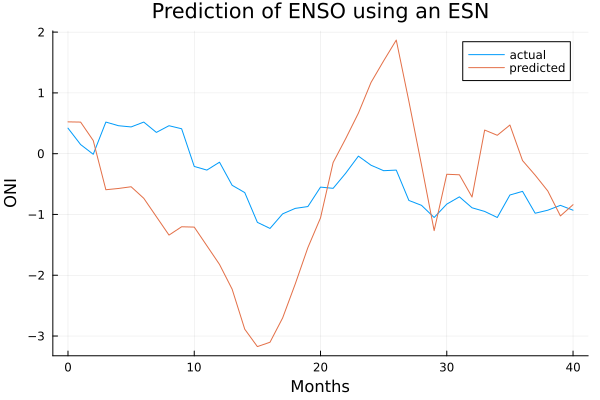

In [158]:
plot_esn_prediction(esn, W_out, test_sst_1D', τ)

## Network training v2

take last column of prediction

#### tools

In [196]:
function esn_eval_pred(esn::ESN, W_out, data::AbstractMatrix)
    steps_to_predict = size(data,2)
    prediction = esn(Generative(steps_to_predict), W_out)
    return prediction[end,:] # changed this line
end

function plot_esn_prediction(esn::ESN, W_out, data::AbstractMatrix, data_name::String)
    prediction = esn_eval_pred(esn, W_out, data)
    
    label = ["actual" "predicted"]
    times =  collect(0:size(data,2))[1:end-1]

    plot(times, [data[1,:], prediction], label=label, ylabel="ONI", xlabel="Months", title="Prediction of ENSO using an ESN $data_name")
end

function cross_validate_esn(train_data::AbstractMatrix, val_data::AbstractMatrix, param_grid::Vector)
    best_loss = Inf
    best_params = nothing

    # We want to predict one step ahead, so the input signal is equal to the target signal from the previous step
    # i.e. the sequence is shifted by one step
    u_train = train_data[:, 1:end-1]
    y_train = train_data[:, 2:end]
        
    for hyperparams in param_grid        
        # Unpack the hyperparams struct
        (; reservoir_size, spectral_radius, sparsity, input_scale, ridge_param) = hyperparams

        # Generate and train an ESN
        esn = ESN(
            u_train,
            size(train_data, 1),
            reservoir_size;
            reservoir=rand_sparse(; radius=spectral_radius, sparsity=sparsity),
            input_layer=scaled_rand(; scaling=input_scale),
        )
        Wₒᵤₜ = enso_project.train_esn!(esn, y_train, ridge_param)

        # Evaluate the loss on the validation set
        steps_to_predict = size(val_data, 2)
        prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
        loss = sum(abs2, prediction[end, :] - val_data[1, :]) # changed this line
        
        # Keep track of the best hyperparameter values
        if loss < best_loss
            best_loss = loss
            best_params = hyperparams
            println(best_params)
            println("Validation loss = $best_loss")
        end
    end
    
    # Retrain the model using the optimal hyperparameters on both the training and validation data
    # This is necessary because we don't want errors incurred during validation to affect the test error
    (;reservoir_size, spectral_radius, sparsity, input_scale, ridge_param) = best_params
    data = hcat(train_data, val_data)
    u = data[:, 1:end-1]
    y = data[:, 2:end]
    esn = ESN(
        u,
        size(train_data, 1),
        reservoir_size;
        reservoir=rand_sparse(; radius=spectral_radius, sparsity=sparsity),
        input_layer=scaled_rand(; scaling=input_scale),
    )
    Wₒᵤₜ = enso_project.train_esn!(esn, y, ridge_param)
    
    return esn, Wₒᵤₜ, best_loss
end


cross_validate_esn (generic function with 2 methods)

### training

In [182]:
spectral_radii = [0.8,0.9,1.0]
sparsities = [0.05, 0.1]
input_scales = [0.1,0.8,1.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [100,110,120,130,140,150,160,170,180,190,200]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [183]:
esn, W_out, val_loss = cross_validate_esn(train_sst_emb, val_sst_emb, param_grid)

enso_project.ESNHyperparams(100, 0.8, 0.05, 0.1, 0.0)
Validation loss = 39.152044294369254
enso_project.ESNHyperparams(170, 0.8, 0.05, 0.1, 0.0)
Validation loss = 30.5030377053533
enso_project.ESNHyperparams(180, 0.8, 0.05, 0.1, 0.0)
Validation loss = 23.797818102329753
enso_project.ESNHyperparams(190, 0.8, 0.05, 0.1, 0.0)
Validation loss = 22.02483896020752
enso_project.ESNHyperparams(190, 0.9, 0.05, 0.1, 0.0)
Validation loss = 21.14516260780882
enso_project.ESNHyperparams(120, 1.0, 0.05, 0.1, 0.0)
Validation loss = 20.514115140182806
enso_project.ESNHyperparams(170, 1.0, 0.05, 0.1, 0.0)
Validation loss = 17.01100252384308
enso_project.ESNHyperparams(130, 0.8, 0.05, 0.8, 0.0)
Validation loss = 9.98188295948097
enso_project.ESNHyperparams(180, 0.9, 0.1, 0.8, 0.0)
Validation loss = 9.828382556671304
enso_project.ESNHyperparams(180, 0.9, 0.1, 1.0, 0.0)
Validation loss = 9.315370553694091
enso_project.ESNHyperparams(200, 1.0, 0.1, 1.0, 0.0)
Validation loss = 8.29896878274248


(ESN(5 => 200), OutputLayer successfully trained with output size: 5, 8.29896878274248)

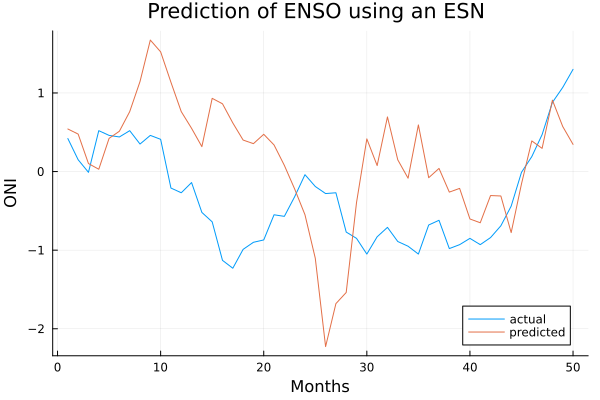

In [192]:
plot_esn_prediction(esn, W_out, test_sst_1D', "")

## error analysis

In [205]:
train_size = 250
initial_val_size = 40;

In [240]:
N = 100
L = 30;

### tools

In [241]:
function sample_lead_times(L, N, data, train_size, initial_val_size, param_grid)
    datasets_test = zeros(N,L)
    predictions = zeros(N,L)

    for n in 0:(N-1)
        # include data shift n
        train_data = data[1:train_size]
        val_data = data[train_size+1:train_size+initial_val_size+n]
        test_data = data[train_size+initial_val_size+n+1:train_size+initial_val_size+n+L]

        # perform data embedding
        train_data_emb, τ, E = optimal_separated_de(train_data)
        train_data_emb = Matrix(train_data_emb)'
        val_data_emb = embed(val_data, size(train_data_emb,1), τ)
        val_data_emb = Matrix(val_data_emb)'

        # train
        esn, W_out, val_loss = cross_validate_esn(train_data_emb, val_data_emb, param_grid) 
        prediction = esn_eval_pred(esn, W_out, test_data')

        # store 
        datasets_test[n+1,:] = test_data
        predictions[n+1,:] = prediction

        # progress control
        println("Finished sample $(n+1)")
    end
    return predictions, datasets_test
end

sample_lead_times (generic function with 1 method)

In [242]:
"""
    function rmse(predictions::AbstractMatrix, test_data::AbstractMatrix)
       
compute the rmse between predicitons and test data for each lead time. Is considered good if smaller 1.4.

# Arguments:
    - `predicitons::AbstractMatrix`: predictions, NxL matrix. N is sample size per lead time, L is all lead times considered
    - `test_data::AbstractMatrix`: test data for each sample, NxL matrix.

# Returns:
    - `Vector`: RMSE for each lead time, vector of length L
"""
function rmse(predictions::AbstractMatrix, test_data::AbstractMatrix)
    N, L = size(predictions, 1), size(predictions,2)
    sse_vals = zeros(N,L)
    sse_vals = (predictions .- test_data).^2
    rmse = sqrt.(sum(sse_vals, dims=1) ./N)
    return rmse[1,:]
end

"""
    function pcc(predictions::AbstractMatrix, test_data::AbstractMatrix)

Compute the Pearson-Correlation-Coefficient between sample and test data for each lead time considered. I.e., PCC is computed between respective data columns.
Is considered good, if > 0.5.

# Arguments:
    - `predicitons::AbstractMatrix`:  predictions, NxL matrix. N is sample size per lead time, L is all lead times considered
    - `test_data::AbstractMatrix`: test data for each sample, NxL matrix.

# Returns:
    - `Vector`: PCC for each lead time, vector of length L
"""
function pcc(predictions::AbstractMatrix, test_data::AbstractMatrix)
    L = size(predictions, 2)
    return [cor(predictions[:,i], test_data[:,i]) for i in 1:L]
end

"""
    function hss(predictions::AbstractMatrix, test_data::AbstractMatrix)

Measures accuracy of predictions (wrt randomly generated forecast). ENSO predicted if abs(ONI)>0.5. Compute ratio out of TP,TN,FP,FN.
Is considered good if >0.5.
Formula from paper "Long-term ENSO prediction with echo-state networks" by Hassanibesheli F. et al.

# Arguments:
    - `predicitons::AbstractMatrix`:  predictions, NxL matrix. N is sample size per lead time, L is all lead times considered
    - `test_data::AbstractMatrix`: test data for each sample, NxL matrix.

# Returns:
    - `Vector`: HSS for each lead time, vector of length L
"""
function hss(predictions::AbstractMatrix, test_data::AbstractMatrix)

    # predict event if indec > 0.5
    events_pred = abs.(Int.(round.(predictions)))
    events_true = abs.(Int.(round.(test_data)))

    # compute TN
    TN_mat = events_pred + events_true
    TN = sum(TN_mat .== 0, dims=1)

    # compute FP,FN,TP
    compare = events_pred - events_true # matrix: 0 for TP, TN; 1 for FP, -1 for FN
    FP = sum(compare .== 1, dims=1)
    FN = sum(compare .==-1, dims=1)
    TP = sum(compare .==0, dims=1) .- TN

    N = TN + TP + FN + FP # should be sample size

    # calculate formula
    CRF = ((TP .+ FN) .* (TP .+ FP) .+ (TN .+ FN) .* (TN .+ FP)) ./ N
    HSS = (TP .+ TN .- CRF) ./ (N .- CRF)
    return HSS[1,:]
end


hss

### generate samples

In [243]:
data = sst_1D[!,"ANOM_3"];

In [244]:
predictions, datasets_test = sample_lead_times(L,N,data, train_size, initial_val_size,param_grid);

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.
enso_project.ESNHyperparams(100, 0.8, 0.05, 0.1, 0.0)
Validation loss = 23.40981835882758
enso_project.ESNHyperparams(110, 0.8, 0.05, 0.1, 0.0)
Validation loss = 21.32656684094738
enso_project.ESNHyperparams(120, 0.8, 0.05, 0.1, 0.0)
Validation loss = 8.044787003738161
enso_project.ESNHyperparams(130, 0.9, 0.05, 0.8, 0.0)
Validation loss = 5.871614746106744
enso_project.ESNHyperparams(160, 1.0, 0.05, 0.8, 0.0)
Validation loss = 5.17186396971494
enso_project.ESNHyperparams(120, 0.9, 0.1, 0.8, 0.0)
Validation loss = 2.771066733066239
Finished sample 1
Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.
enso_project.ESNHyperparams(100, 0.8, 0.05, 0.1, 0.0)
Validation loss = 27.68502446186255
enso_project.ESNHyperparams(110, 0.8, 0.05, 0.1, 0.0)
Validation loss = 25.5890835469613
enso_project.ESNHyperparams(120, 0.8, 0.05, 0.1, 0.0)
Validation loss = 8.419782022766263
enso_projec

### evaluate errors

In [245]:
pcc_vals = pcc(predictions, datasets_test);
rmse_vals = rmse(predictions, datasets_test);
hss_vals = hss(predictions, datasets_test);

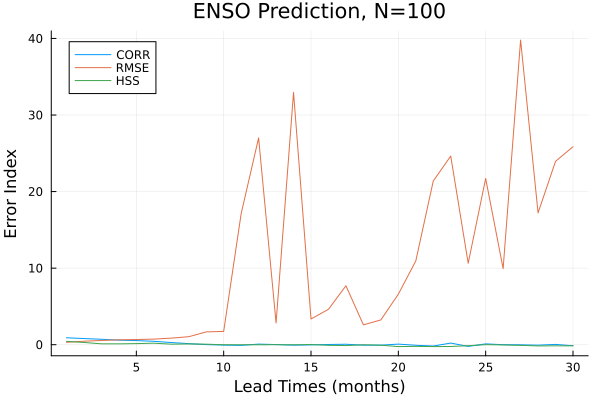

In [249]:
plot(pcc_vals, label="CORR", xlabel="Lead Times (months)", ylabel="Error Index", title="ENSO Prediction, N=100")
plot!(rmse_vals, label="RMSE")
plot!(hss_vals, label="HSS")

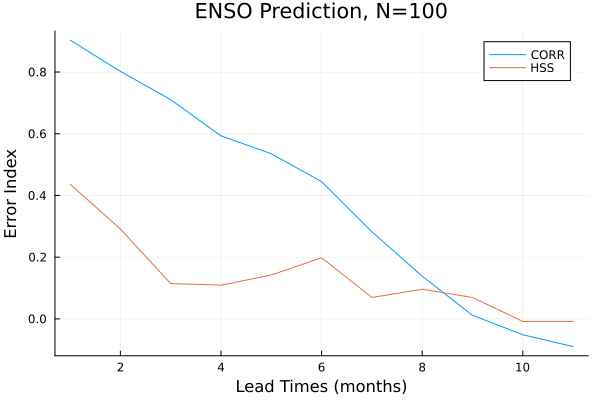

In [248]:
plot(pcc_vals[1:11], label="CORR", xlabel="Lead Times (months)", ylabel="Error Index", title="ENSO Prediction, N=100")
plot!(hss_vals[1:11], label="HSS")

### store

In [ ]:
CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/redo_enso/errors/enso_L$(L)_N$(N)_predictions.csv", DataFrame(predictions, :auto))
CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/redo_enso/errors/enso_L$(L)_N$(N)_testsets.csv", DataFrame(datasets_test, :auto))

In [ ]:
#predictions = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/redo_enso/errors/enso_L$(L)_N$(N)_predictions.csv", DataFrame))
#datasets_test = Matrix(CSV.read("C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/redo_enso/errors/enso_L$(L)_N$(N)_testsets.csv", DataFrame));
